In [17]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [18]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

In [19]:
def compute_discounted_rewards(rewards, gamma=0.99):
    discounted = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted.insert(0, R)
    return torch.tensor(discounted)

In [52]:
def train(env, policy, optimizer, episodes=1000):
    episode_rewards = []  # Move this inside
    best_reward = float('-inf')
    best_episode = {
        "reward": 0,
        "trajectory": []
    }

    for episode in range(episodes):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        trajectory = []
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            probs = policy(state_tensor)
            m = Categorical(probs)
            action = m.sample()

            log_probs.append(m.log_prob(action))

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            rewards.append(reward)
            trajectory.append((state, action.item(), reward))
            state = next_state

        total_reward = sum(rewards)
        episode_rewards.append(total_reward)

        # Save the best episode
        if total_reward > best_reward:
            best_reward = total_reward
            best_episode["reward"] = total_reward
            best_episode["trajectory"] = trajectory

        discounted_rewards = compute_discounted_rewards(rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        policy_loss = []
        for log_prob, Gt in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * Gt)

        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()

        if episode % 50 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return episode_rewards, best_episode

In [53]:
env = gym.make('CartPole-v1')
policy = PolicyNetwork()
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [62]:
rewards, best_episode = train(env, policy, optimizer)

print("\n")
print("="*50)

print(f"\nBest Episode Reward: {best_episode['reward']}")
print("Sample of Best Episode Trajectory:")
for step in best_episode["trajectory"][:5]:
    state, action, reward = step
    print(f"State: {state}, Action: {action}, Reward: {reward}")

Episode 0, Total Reward: 349.0
Episode 50, Total Reward: 500.0
Episode 100, Total Reward: 500.0
Episode 150, Total Reward: 365.0
Episode 200, Total Reward: 500.0
Episode 250, Total Reward: 322.0
Episode 300, Total Reward: 500.0
Episode 350, Total Reward: 500.0
Episode 400, Total Reward: 500.0
Episode 450, Total Reward: 500.0
Episode 500, Total Reward: 310.0
Episode 550, Total Reward: 223.0
Episode 600, Total Reward: 200.0
Episode 650, Total Reward: 421.0
Episode 700, Total Reward: 429.0
Episode 750, Total Reward: 500.0
Episode 800, Total Reward: 250.0
Episode 850, Total Reward: 298.0
Episode 900, Total Reward: 300.0
Episode 950, Total Reward: 500.0



Best Episode Reward: 500.0
Sample of Best Episode Trajectory:
State: [-0.04987774 -0.03810657 -0.04229632 -0.04380351], Action: 0, Reward: 1.0
State: [-0.05063987 -0.23259729 -0.04317239  0.23524024], Action: 1, Reward: 1.0
State: [-0.05529182 -0.03688596 -0.03846759 -0.07074196], Action: 1, Reward: 1.0
State: [-0.05602954  0.15876576 -0.

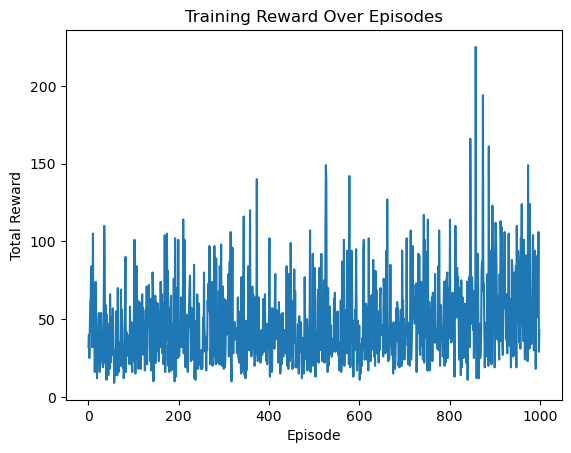

In [60]:
plt.plot(episode_rewards)
plt.title("Training Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()